## Init

In [1]:
import random 
from scipy import stats
import statistics
import timeit
import scipy.stats
import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm as tqdm
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import time
from IPython import display
from multiprocessing import Pool

plt.rcParams['figure.figsize'] = [24, 16]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


%matplotlib inline

## Zadanie 1

## Zadanie 2

## Zadanie 3

In [2]:
image_shape = (106, 148)

# data from the satellite, only classes 3, 7, 9
def sanitize_class(class_):
    cl = [float(c) for c in class_.split(" ") if len(c) > 1]
    return cl
    
def SuccRawImageData():
    data = []
    with open("ImageRawReduced.txt", "r") as f:
        c1, c2, c3, _ = f.read().split("\n")
        c1 = sanitize_class(c1)
        c2 = sanitize_class(c2)
        c3 = sanitize_class(c3)
        return [c1, c2, c3]

# desired classification data, classes 1, 2, 3
def SuccExpertImageData():
    data = []
    with open("ImageExpertReduced.txt", "r") as f:
        c1 = (f.read().split("\n"))[0]
        return sanitize_class(c1)
    
def SuccClasificationRules():
    ruleset = []
    with open("ClassificationRules.txt", "r") as f:
        for rule in f.read().split("\n"):
            if len(rule) > 10:
                ruleset.append(sanitize_class(rule))
    return ruleset
    
raw_data = SuccRawImageData()
desired_data = SuccExpertImageData()
classification_rules = SuccClasificationRules()
print(f"loaded {len(classification_rules)} classification rules")
print(f"rule 0 is {len(classification_rules[0])} dimentions long")

def softsort(b):
    if b[0] >= b[1] and b[0] >= b[2]:
        return 1
    elif b[1] >= b[0] and b[1] >= b[2]:
        return 2
    elif b[2] >= b[1] and b[2] >= b[0]:
        return 3    

def calculate_score(test_data, desired_data):
    assert len(test_data) == len(desired_data)
    correct = 0
    for it in range(len(test_data)):
        if test_data[it] == desired_data[it]:
            correct += 1
    return float(correct)/float(len(test_data))

def continuous_bucket_score(test_buckets, desired_data):
    score = 0.0
    for it in range(len(test_buckets)):        
        if softsort(test_buckets[it]) == desired_data[it]:
            score += 10.0
        else:
            mx = float(max(test_buckets[it][oi] for oi in range(3)))
            score += test_buckets[it][int(desired_data[it]) - 1]/mx * 2.0
            score -= test_buckets[it][0]/mx
            score -= test_buckets[it][1]/mx
            score -= test_buckets[it][2]/mx
    return score
            
for i in range(10):
    print(calculate_score(classification_rules[i], desired_data))

loaded 266 classification rules
rule 0 is 9350 dimentions long
0.6453475935828877
0.7038502673796792
0.4702673796791444
0.4760427807486631
0.4709090909090909
0.4918716577540107
0.533903743315508
0.47689839572192516
0.5820320855614973
0.6253475935828877


In [3]:
def bake(specimen, method = 'cont', verbose = False):
    buckets = np.zeros((len(classification_rules[1]), 3))

    if verbose:
        print(f"initializing bucket with {len(classification_rules[1])}x{3}")
    
    # ruleit to reguła, gene to jej waga
    for ruleit, gene in enumerate(specimen):
        for tid, target in enumerate(classification_rules[ruleit]):
            buckets[int(tid)][int(target) - 1] += gene

    baked = []
    
    for b in buckets:
        baked.append(softsort(b))
    
    if verbose:
        print(len(baked), len(buckets), len(desired_data))
    
    if method == 'disc':
        return calculate_score(baked, desired_data)
    
    if method == 'cont':
        return continuous_bucket_score(buckets, desired_data)

def render(specimen):
    buckets = np.zeros((len(classification_rules[1]), 3))

    for ruleit, gene in enumerate(specimen):
        for tid, target in enumerate(classification_rules[ruleit]):
            buckets[int(tid)][int(target) - 1] += gene

    baked = []
    
    for b in buckets:
        baked.append(softsort(b))
    return baked
    
    
fail = False
for i in range(10):
    genome = [0.0 for j in classification_rules]
    genome[i] = 1.0
    scorea = bake(genome, 'disc')
    scoreb = calculate_score(classification_rules[i], desired_data)
    if scorea != scoreb:
        fail = True
        print(f"bake returned {scorea}, expected {scoreb}")
        
if fail:
    print("bake tests failed")
else:
    print("bake tests passed")

bake tests passed


In [4]:
genome = [random.random() for i in classification_rules]
learning_rate = 0.1
mut_prob = 0.01
mut_shift = 0.02

def dump_file(genome, fitness):
    with open(f"genedump_{fitness}_.txt", "w") as f:
        for g in genome:
            f.write(f"{g}\n")
            
record = 1.0
best, mean, stdev = [], [], []
iteration = []
static_score = []
geneh = [[] for i in range(20)]

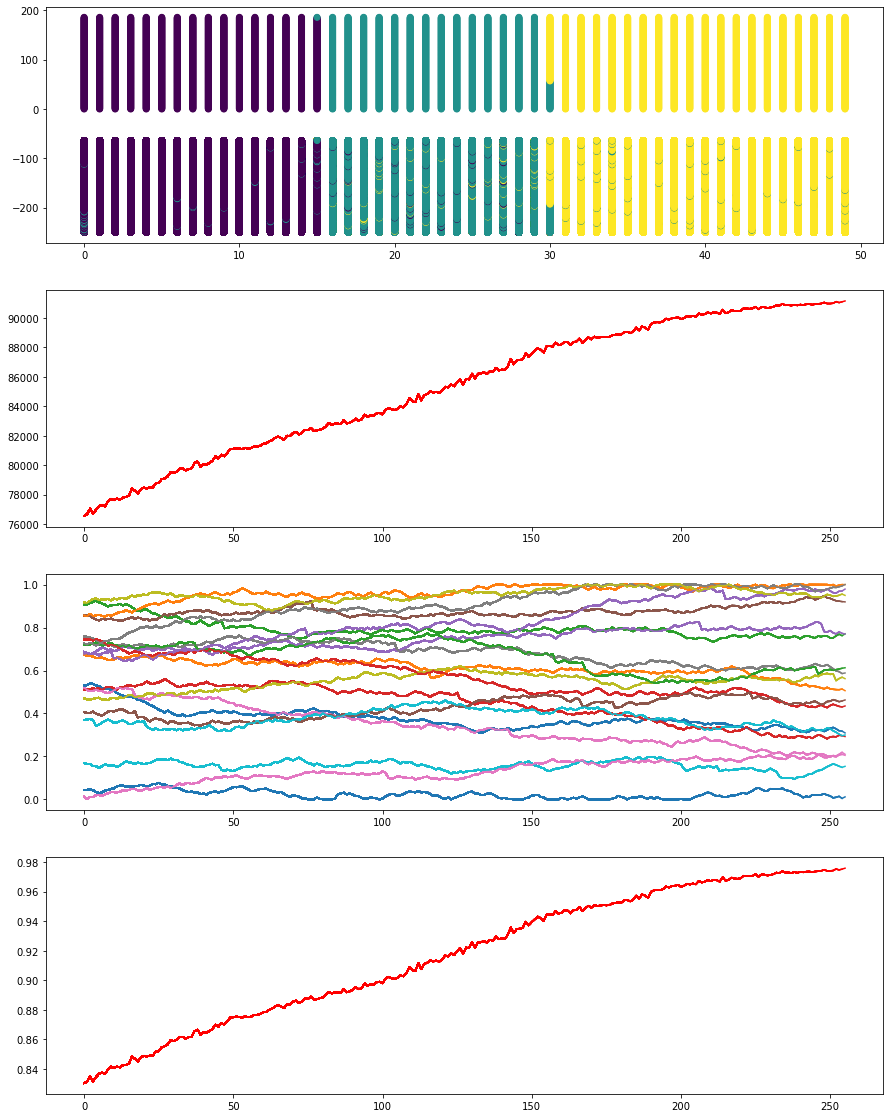

In [ ]:
population_size = 64
fig, ax = plt.subplots()
fig, (td, ax0, ax1, ax2) = plt.subplots(nrows=4, constrained_layout=False, figsize = (15, 20))

yd = int(9350/(11*17))
xd = 11*17

fyp = []
fxp = []
for i in range(yd):
    for j in range(xd):
        fyp.append(i)
        fxp.append(j)
        
td.scatter(fyp, fxp, c = [int(c) for c in desired_data])

for i in range(512):
    #print("------")
    iteration.append(i)
    # create population
    population = []
    for _ in range(population_size):
        population.append([
            learning_rate - random.random() * 2.0 * learning_rate + genome[i] for i in range(len(classification_rules))
        ])
    
    # evauate population
    scores = []
    
    #scores = [bake(s) for s in population]
    with Pool(8) as p:
        scores = p.map(bake, population)
    
    #print(max(scores)) 
    #print(genome[:10])
    leaderboard = np.argsort(scores)

    best.append(max(scores))
    # draw graphs
    td.scatter(fyp, [x-250 for x in fxp], c = [int(c) for c in render(population[leaderboard[-1]])])

    static_score.append(bake(population[leaderboard[-1]], "disc"))
    
    for i in range(20):
        geneh[i].append(genome[10*i])
    
    #print(iteration, best)
    ax0.plot(iteration, best, color='red')
    for i in range(20):
        ax1.plot(iteration, geneh[i])
        
    ax2.plot(iteration, static_score, color='red')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.01)
 
    # pick winner

    if record < scores[leaderboard[-1]]:
        #print(f"new record!!! {record} -> {scores[leaderboard[0]]}")
        record = scores[leaderboard[-1]]
        dump_file(genome, record)
    
    # generate kids
    for vdim in range(len(classification_rules)):
        if random.random() < mut_prob:
            if random.random() > 0.5:
                genome[vdim] = (1.0 - mut_shift) * genome[vdim] + mut_shift
            else:
                genome[vdim] = (1.0 - mut_shift) * genome[vdim] - mut_shift
        else:
            genome[vdim] = (1.0 - learning_rate) * genome[vdim] + learning_rate * population[leaderboard[-1]][vdim]

        genome[vdim] = max(min(1.0, genome[vdim]), 0.0)
